In [1]:
import numpy as np
import matplotlib.pyplot as plt

from data_loader import image_loader
from data_loader import image_augmentation as aug
from models import double_decoder_cnn

from tqdm.notebook import tqdm
import json

2023-02-04 18:22:59.583782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 18:23:00.253931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /srv/data/Apps/hdf5/lib:/usr/local/cuda-11.2/lib64:/srv/data/gcc-11.2.0/libexec/gcc/x86_64-pc-linux-gnu/11.2.0:/srv/data/gcc-11.2.0/lib:/srv/data/gcc-11.2.0/lib32:/srv/data/gcc-11.2.0/lib64:/srv/data/Apps/local/lib:/srv/data/Apps/hunspell/lib:
2023-02-04 18:23:00.254022: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print(f"TensorFlow version: {tf.__version__}")
print("number of GPUs available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

TensorFlow version: 2.11.0
number of GPUs available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4789901823684147021
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23371513856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13974775622228462833
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-02-04 18:23:00.917778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 18:23:01.436306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [3]:
training_data_dir = "../training_data"
network_param_dir = "../network_params"
output_dir = "../outputs"

network_name_str = "semisupervised_2023_02"

save_figures = True
save_network = True
load_network = True

trn_dim = 256
test_split_fraction = 0.1
batch_size = 1

# Data preparation

In [4]:
data_generator_img_img = image_loader.ImageLoader(dataset_folders=None,
                                 test_split_fraction=test_split_fraction,
                                 use_labels=False,
                                 image_processing_function=image_loader.image_preprocessing_function,
                                 label_processing_function=None)

In [5]:
data_generator_img_lbl = image_loader.ImageLoader(dataset_folders=None,
                                 test_split_fraction=test_split_fraction,
                                 use_labels=True,
                                 image_processing_function=image_loader.image_preprocessing_function,
                                 label_processing_function=image_loader.label_preprocessing_function)

It is assumed that the training data is present in ```training_data_dir```. Please download the training data into this directory from http://dx.doi.org/10.17169/refubium-37222.

In [6]:
data_generator_img_img.load_from_file(f"{training_data_dir}/dataset_images_{network_name_str}")
data_generator_img_lbl.load_from_file(f"{training_data_dir}/dataset_image_labels_{network_name_str}")

Loading zipped datasets from file...done!
Max. image dimensions = 1324
Loading zipped datasets from file...done!
Max. image dimensions = 1324


In [7]:
print(f"max. dataset size (image-image) = {len(data_generator_img_img.trn_img_list)}")
print(f"max. dataset size (image-label) = {len(data_generator_img_lbl.trn_img_list)}")

max. dataset size (image-image) = 461
max. dataset size (image-label) = 71


75.97349


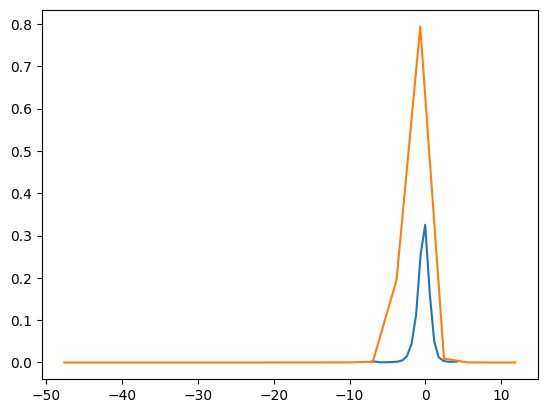

In [8]:
hist, bin_edges = np.histogram(data_generator_img_lbl.test_img_list, bins=20)
hist = hist / np.sum(hist)

plt.plot(bin_edges[:-1], hist)

hist, bin_edges = np.histogram(data_generator_img_img.test_img_list, bins=20)
hist = hist / np.sum(hist)

plt.plot(bin_edges[:-1], hist)

img_value_range = np.amax(data_generator_img_img.trn_img_list) - np.amin(data_generator_img_img.trn_img_list)

print(img_value_range)

In [9]:
trn_input_img_img, test_input_img_img = data_generator_img_img.get_dataset()
trn_input_img_lbl, test_input_img_lbl = data_generator_img_lbl.get_dataset()

Compiling tensorflow datasets...

2023-02-04 18:23:07.988517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2023-02-04 18:23:07.989640: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3232487744 exceeds 10% of free system memory.
2023-02-04 18:23:09.279934: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3232487744 exceeds 10% of free system memory.
2023-02-04 18:23:10.082713: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3232487744 exceeds 10% of free system memory.
2023-02-04 18:23:11.221542: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3232487744 exceeds 10% of free system memory.


done!
Compiling tensorflow datasets...done!


In [10]:
augmentation_func_img_img = aug.augmentation_function(data_generator_img_img.max_dim, trn_dim,
                                              random_rotation=True,
                                              random_reflection=True,
                                              random_contrast=False)

training_dataset_img_img = trn_input_img_img.\
                    repeat(batch_size).\
                    map(map_func=augmentation_func_img_img).\
                    shuffle(len(trn_input_img_img) * batch_size, reshuffle_each_iteration=True).\
                    batch(batch_size)


test_dataset_img_img = test_input_img_img.\
                    repeat(batch_size).\
                    map(map_func=augmentation_func_img_img).\
                    batch(batch_size)

augmentation_func_img_lbl = aug.augmentation_function(data_generator_img_lbl.max_dim, trn_dim,
                                              random_rotation=True,
                                              random_reflection=True,
                                              random_contrast=False)

training_dataset_img_lbl = trn_input_img_lbl.\
                    repeat(batch_size * 6).\
                    map(map_func=augmentation_func_img_lbl).\
                    shuffle(len(trn_input_img_lbl) * batch_size * 6, reshuffle_each_iteration=True).\
                    batch(batch_size)


test_dataset_img_lbl = test_input_img_lbl.\
                    repeat(batch_size * 6).\
                    map(map_func=augmentation_func_img_lbl).\
                    batch(batch_size)

print(training_dataset_img_img.cardinality)
print(training_dataset_img_lbl.cardinality)

<bound method DatasetV2.cardinality of <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>>
<bound method DatasetV2.cardinality of <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>>


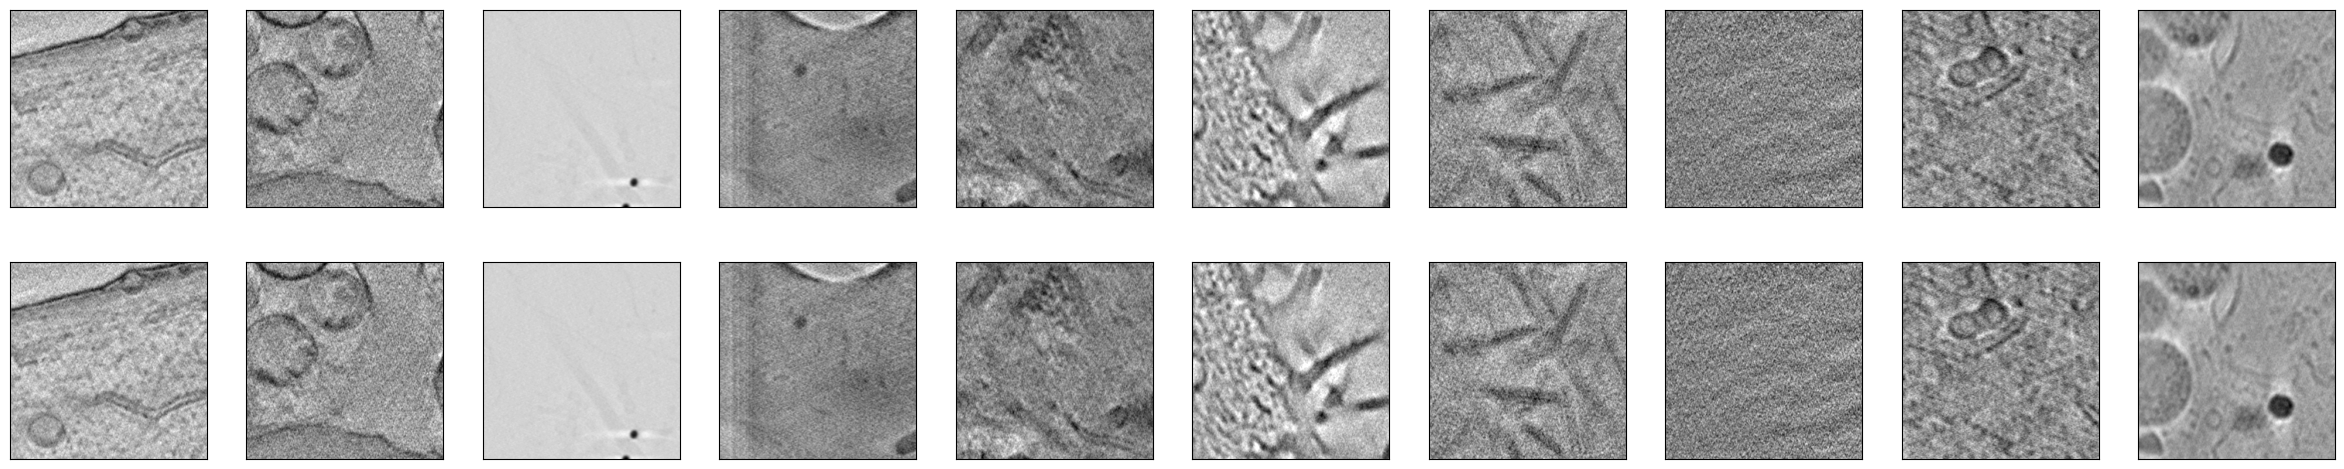

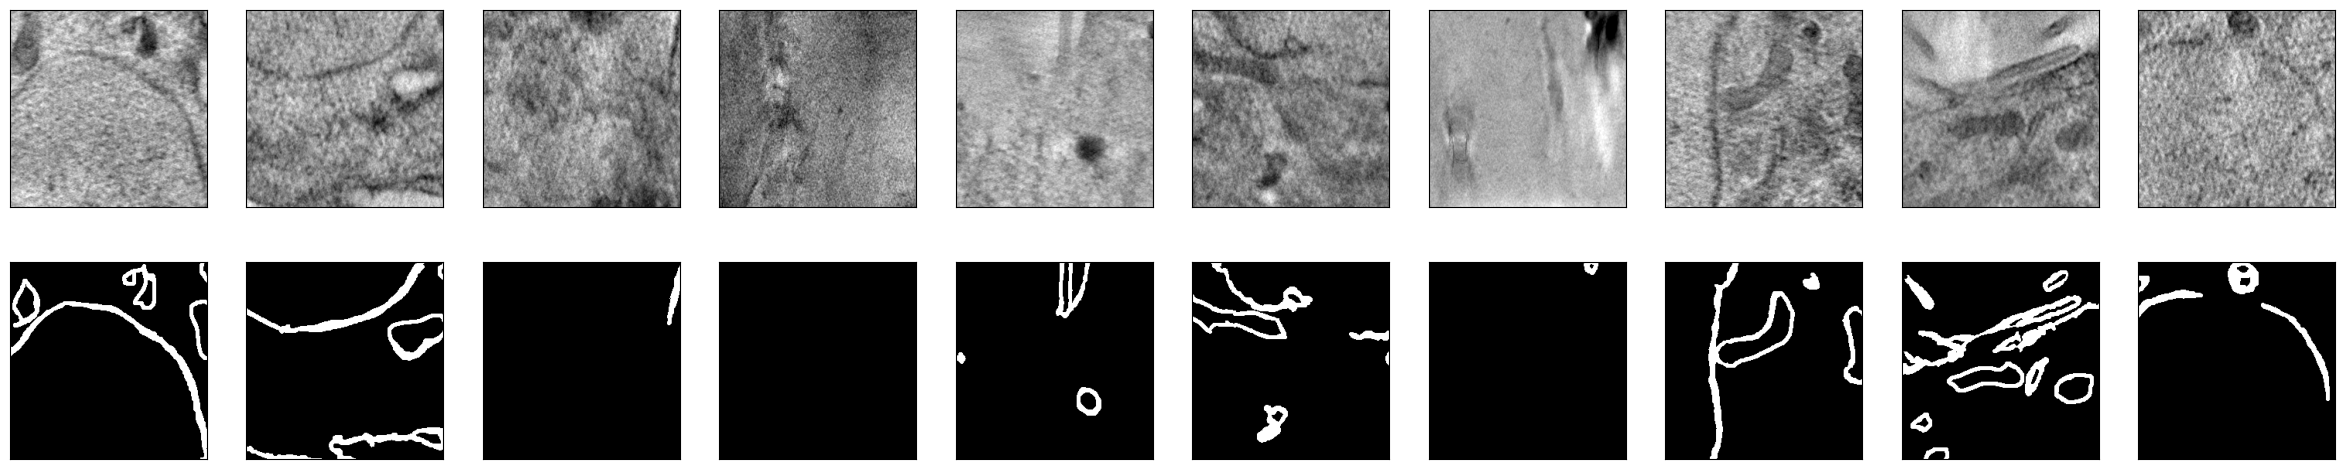

In [11]:
def show_samples(fig, _iter, n_images):
    
    for i in range(n_images):
        img_list, lbl_list = next(_iter)
        img, lbl = img_list[0], lbl_list[0]

        ax = [fig.add_subplot(2, n_images, i + 1), fig.add_subplot(2, n_images, i + n_images + 1)]
        ax[0].imshow (img[:, :, 0], cmap='gray')
        ax[1].imshow (lbl[:, :, 0], cmap='gray')
        
        for _ax in ax:
            _ax.tick_params(axis='both', which='both',
                            bottom=False, top=False, left=False, right=False,
                            labelbottom=False, labelleft=False)
        
n_images = 10
_fig_size = (3.0 * n_images, 3.0 * 2)

fig = plt.figure (figsize=_fig_size)
show_samples(fig, test_dataset_img_img.as_numpy_iterator(), n_images)

fig = plt.figure (figsize=_fig_size)
show_samples(fig, test_dataset_img_lbl.as_numpy_iterator(), n_images)

# Network definition

In [12]:
m_f = 64

encoder_config = {'kernel_sizes': [3, 3, 3, 3, 3],
                  'n_stages': 4, 'n_blocks': 1, 'block_depth': 2,
                  'add_instead_of_concat':False,
                  'n_filters': [m_f, m_f, 2 * m_f, 4 * m_f, 8 * m_f],
                  'activation': {'type': 'relu'},
                  'dropout': {'active': False},
                  'batch_norm': {'active': True}}

neck_config = {'kernel_sizes': [1, 2, 3],
               'depth': 4, 'n_filters': 16 * m_f,
               'activation': {'type': 'relu'},
               'dropout': {'active': False},
               'batch_norm': {'active': True}}

decoder_image_config = {'kernel_sizes': [3, 3, 3, 3, 3],
                        'n_stages': 4, 'n_blocks': 1, 'block_depth': 2,
                        'add_instead_of_concat':False,
                        'use_skip_connections': False,
                        'n_filters': [8 * m_f, 4 * m_f, 2 * m_f, m_f, m_f],
                        'activation': {'type': 'relu'},
                        'dropout': {'active': False},
                        'batch_norm': {'active': True}}

decoder_label_config = {'kernel_sizes': [3, 3, 3, 3, 3],
                        'n_stages': 4, 'n_blocks': 2, 'block_depth': 2,
                        'add_instead_of_concat':False,
                        'use_skip_connections': True,
                        'n_filters': [8 * m_f, 4 * m_f, 2 * m_f, m_f, m_f],
                        'activation': {'type': 'relu'},
                        'dropout': {'active': False},
                        'batch_norm': {'active': True}}


model_config = {'pooling': None, 'm_f': m_f, 'add_instead_of_concat_after_neck': False,
                              'encoder': encoder_config,
                              'neck': neck_config,
                              'decoder_image': decoder_image_config,
                              'decoder_label': decoder_label_config}


if save_network:
    with open(f"{network_param_dir}/model_config_{network_name_str}.json", 'w') as f_conf:
        json.dump(model_config, f_conf, indent=4)

In [13]:
dd_model = double_decoder_cnn.MyDoubleDecoderNet(config=model_config)

dd_model.build(input_shape=(None, trn_dim, trn_dim, 1))

dd_model.summary ()

skip connections in image decoder: False
skip connections in label decoder: True


/srv/data/miniconda3/envs/Tomo/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "my_double_decoder_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (MyEncoderBlock)    multiple                  2286240   
                                                                 
 mid_branch_0 (MyMidBranchBl  multiple                 5259264   
 ock)                                                            
                                                                 
 mid_branch_1 (MyMidBranchBl  multiple                 8404992   
 ock)                                                            
                                                                 
 mid_branch_2 (MyMidBranchBl  multiple                 13647872  
 ock)                                                            
                                                                 
 image_decoder (MyDecoderBlo  multiple                 19543488  
 ck)                                         

## Preloading network weights

In [14]:
if load_network:
    dd_model.load_weights(f"{network_param_dir}/weights_{network_name_str}.h5")

## Training

In [15]:
def image_reconstruction_loss(input_img, y_true, y_pred):
    
    alpha = 0.5
    
    return alpha * (tf.math.reduce_sum(1.0 - tf.image.ssim(input_img, y_pred[0],
                                                           img_value_range, filter_size=11, filter_sigma=1.5,
                                                           k1=0.01, k2=0.03), axis=0)) +\
            (1.0 - alpha) * tf.keras.losses.Huber(delta=0.1)(input_img, y_pred[0]) +\
            tf.keras.losses.MeanSquaredError()(y_pred[1], y_pred[1])

def label_loss(input_img, y_true, y_pred):
    
    alpha = 0.99
    
    return (1.0 - alpha) * tf.keras.losses.Huber(delta=0.1)(input_img, y_pred[0]) +\
           alpha * tf.keras.losses.Huber(delta=0.1)(y_true, y_pred[1])  

def label_only_loss(input_img, y_true, y_pred):
    
    return tf.keras.losses.Huber(delta=0.1)(y_true, y_pred[1]) +\
           tf.keras.losses.MeanSquaredError()(y_pred[0], y_pred[0])

def label_accuracy_function(label, prediction):

    prediction = tf.clip_by_value(0.5 * (prediction[1] + tf.ones_like(prediction[1])), 0.0, 1.0)
    label = tf.clip_by_value(0.5 * (label + tf.ones_like(label)), 0.0, 1.0)
    
    num_of_pixels = tf.reduce_sum(tf.ones_like(label))
    num_of_correct_pixels = tf.reduce_sum(
        tf.cast(tf.math.less_equal(tf.abs(label - prediction), 0.01 * tf.ones_like(label)), dtype=tf.float32))
                                                         
    pred_score = num_of_correct_pixels / num_of_pixels
    
    return tf.clip_by_value(pred_score, 0.0, 1.0)

def comprehensive_label_accuracy_function(label, prediction):
    
    tol = 1.0e-3
    
    _prediction = np.squeeze(prediction[1].numpy())
    _label = np.squeeze(label.numpy())
    
    total_num_of_pixels = np.prod(_label.shape)
    
    _prediction_positive = (_prediction > 0.9).astype(np.float64)
    _label_positive = (_label > 0.9).astype(np.float64)

    _prediction_negative = (_prediction < -0.9).astype(np.float64)
    _label_negative = (_label < -0.9).astype(np.float64)
    
    true_positive = (_prediction_positive * _label_positive).astype(np.float64)
    true_negative = (_prediction_negative * _label_negative).astype(np.float64)

    false_positive = (_prediction_positive * _label_negative).astype(np.float64)
    false_negative = (_prediction_negative * _label_positive).astype(np.float64)
    
    num_true_positive = np.sum (true_positive)
    num_true_negative = np.sum (true_negative)
    
    num_false_positive = np.sum (false_positive)
    num_false_negative = np.sum (false_negative)
    
    accuracy = (num_true_positive + num_true_negative) / total_num_of_pixels
    
    precision = num_true_positive / (num_true_positive + num_false_positive + 1.0e-16)
    recall = num_true_positive / (num_true_positive + num_false_negative + 1.0e-16)
    
    F1_score = 2.0 * num_true_positive / (2.0 * num_true_positive + num_false_positive + num_false_negative + 1.0e-16)
    
    return accuracy, precision, recall, F1_score

def image_accuracy_function(label, prediction):

    num_of_pixels = tf.reduce_sum(tf.ones_like(label))
    num_of_correct_pixels = tf.reduce_sum(
        tf.cast(tf.math.less_equal(tf.abs(label - prediction[0]), tf.ones_like(label) * tf.math.reduce_std(label)), dtype=tf.float32))

    pred_score = num_of_correct_pixels / num_of_pixels

    return tf.clip_by_value(pred_score, 0.0, 1.0)

In [16]:
class MyDoubleTrainer:
    
    def __init__(self, model, training_dataset, test_dataset, learning_rate=5.0e-5,
                 optimizer=None, loss_function=None, accuracy_function=None, extended_accuracy_function=None):

        self.model = model
        self.training_dataset = training_dataset
        self.test_dataset = test_dataset

        if optimizer is None:
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        self.optimizer = optimizer
        self.loss_function = loss_function
        self.accuracy_function = accuracy_function

        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

        self.test_loss = tf.keras.metrics.Mean(name='test_loss')
        self.test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')
        
        self.extended_accuaracy_function = extended_accuracy_function

        self.epoch = None
        self.train_loss_list, self.test_loss_list = None, None
        self.train_accuracy_list, self.test_accuracy_list = None, None

        self.reset_training_loop()

    @tf.function
    def __train_step(self, images, labels):

        with tf.GradientTape() as tape:
            predictions = self.model(images, training=True)
            loss = self.loss_function(images, labels, predictions)
            accuracy = self.accuracy_function(labels, predictions)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.train_loss(loss)
        self.train_accuracy(accuracy)

    @tf.function
    def __test_step(self, images, labels):
        predictions = self.model(images, training=False)

        loss = self.loss_function(images, labels, predictions)
        accuracy = self.accuracy_function(labels, predictions)

        self.test_loss(loss)
        self.test_accuracy(accuracy)

    def reset_training_loop(self):

        self.epoch = 0
        self.train_loss_list = []
        self.test_loss_list = []
        self.train_accuracy_list = []
        self.test_accuracy_list = []

    def estimate_extended_accuracy(self):

        self.test_loss.reset_states()
        self.test_accuracy.reset_states()
        
        loss_list = []
        accuracy_list = []
        
        for test_images, test_labels in self.test_dataset:

            test_predictions = self.model(test_images, training=False)

            accuracy_list.append(self.extended_accuaracy_function (test_labels, test_predictions))

        accuracy_list = np.array(accuracy_list)
        
        #print(f"Test Accuracy:")
        #print(np.mean (accuracy_list, axis=0))

        return np.mean (accuracy_list, axis=0), np.std (accuracy_list, axis=0)

    def one_epoch(self):

        self.train_loss.reset_states()
        self.train_accuracy.reset_states()

        self.test_loss.reset_states()
        self.test_accuracy.reset_states()
        
        for images, labels in tqdm(self.training_dataset):
            self.__train_step(images, labels)

        for test_images, test_labels in tqdm(self.test_dataset):
            self.__test_step(test_images, test_labels)
        
        self.epoch += 1
                
        template = 'Epoch {}, Loss: {:5.4f}, Accuracy: {:5.2f}%, Test Loss: {:5.4f}, Test Accuracy: {:5.2f}%'

        print(template.format(self.epoch,
                                self.train_loss.result(),
                                self.train_accuracy.result() * 100.0,
                                self.test_loss.result(),
                                self.test_accuracy.result() * 100.0))

        self.train_loss_list.append(self.train_loss.result())
        self.train_accuracy_list.append(self.train_accuracy.result())

        self.test_loss_list.append(self.test_loss.result())
        self.test_accuracy_list.append(self.test_accuracy.result())

In [17]:
image_trainer = MyDoubleTrainer(model=dd_model,
                                 training_dataset=training_dataset_img_img,
                                 test_dataset=test_dataset_img_img,
                                 loss_function=image_reconstruction_loss,
                                 accuracy_function=image_accuracy_function)

label_trainer = MyDoubleTrainer(model=dd_model,
                                 training_dataset=training_dataset_img_lbl,
                                 test_dataset=test_dataset_img_lbl,
                                 loss_function=label_loss,
                                 accuracy_function=label_accuracy_function)

In [18]:
image_trainer.reset_training_loop()
label_trainer.reset_training_loop()

In [19]:
n_epochs = 10

for epoch in range(n_epochs):
    
    label_trainer.one_epoch()

    image_trainer.one_epoch()


  0%|          | 0/426 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Saving/loading model and weights

In [ ]:
if save_network:

    dd_model.save_weights(f"{network_param_dir}/weights_{network_name_str}.h5")

    np.savez(f"{output_dir}/loss_{network_name_str}", np.array(image_trainer.train_loss_list),
                                                                    np.array(image_trainer.test_loss_list),
                                                                    np.array(label_trainer.train_loss_list),
                                                                    np.array(label_trainer.test_loss_list),
                                                                    np.array(label_trainer.train_accuracy_list),
                                                                    np.array(label_trainer.test_accuracy_list))

In [ ]:
def plot_learning_curve(_trainer, _label):

    fig = plt.figure()
    plt.plot(_trainer.train_loss_list, alpha=0.7, linewidth=1, label=f"{_label}-training loss")
    plt.plot(_trainer.test_loss_list, alpha=0.7, linewidth=1, label=f"{_label}-test loss")
    plt.xlabel ('Epoch')
    plt.ylabel ('Loss')
    plt.yscale ('log')
    plt.legend ()

    if save_figures:
        fig.savefig(f"{output_dir}/{_label}_loss.pdf",
                format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

    fig = plt.figure()
    plt.plot(100.0 * np.array(_trainer.train_accuracy_list), alpha=0.7, linewidth=1, label=f"{_label}-training accuracy")
    plt.plot(100.0 * np.array(_trainer.test_accuracy_list), alpha=0.7, linewidth=1, label=f"{_label}-test accuracy")
    plt.ylabel ('Accuracy (%)')
    plt.xlabel ('Epoch')
    plt.legend ()

    if save_figures:
        fig.savefig(f"{output_dir}/{_label}_accuracy.pdf",
                format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

plot_learning_curve(image_trainer, "image-image" )
plot_learning_curve(label_trainer, "image-label" )

### Visualizing network predictions

In [ ]:
n = 0

In [ ]:
n_results = 5

fig, ax = plt.subplots(n_results, 4, figsize = (24, n_results * 6.0), gridspec_kw={'wspace':0.1, 'hspace':0.1})

n += 1

for i, (img, lbl) in zip(range(n_results), test_dataset_img_lbl):
    
    output = dd_model(img, training=False)

    gen_image_test = output[0].numpy()
    predicted_label_test = output[1].numpy()

    ind = 0
    
    ax[i, 0].imshow (img[ind, :, :, 0], cmap='gray', interpolation='nearest')
    
    ax[i, 1].imshow (lbl[ind, :, :, 0], cmap='hot', interpolation='nearest', vmin=-1.0, vmax=1.0)
    
    ax[i, 2].imshow (gen_image_test[ind, :, :, 0], cmap='gray', interpolation='nearest')
    
    ax[i, 3].imshow (predicted_label_test[ind, :, :, 0], cmap='hot', interpolation='nearest', vmin=-1.0, vmax=1.0)

    if i == 0:
        ax[i, 0].set_title("original slide", fontsize=22)
        ax[i, 1].set_title("manual label", fontsize=22)
        ax[i, 2].set_title("gen. image", fontsize=22)
        ax[i, 3].set_title("predicted label", fontsize=22)
    
    for j in range(4):
        ax[i, j].tick_params(
            axis='both',
            which='both',
            bottom=False,     
            top=False, 
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False)
        
if save_figures:
    fig.savefig(f"{output_dir}/prediction_{n}.pdf",
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)